# Homework 4

In [268]:
import astropy.units as u
import astropy.constants as c
from astropy.coordinates import SkyCoord
from astropy.time import Time
import numpy as np
import matplotlib.pyplot as plt
import scipy
import pandas as pd
import glob
%matplotlib inline

from astropy.visualization import time_support
import shapely
from numpy.fft import rfft2, rfftfreq, irfft2, rfft, irfft
from shapely.geometry import LineString, Point

In [269]:
plt.rcParams['figure.figsize'] = (10, 10)
plt.rc('axes', labelsize=14)
plt.rc('axes', labelweight='bold')
plt.rc('axes', titlesize=16)
plt.rc('axes', titleweight='bold')
plt.rc('font', family='sans-serif')

# Problem 1

Consider a square potential well of width w, with walls of height V:
V
0
E
w
Using Schr  ̈odinger’s equation, it can be shown that the allowed energies E of a single quantum
particle of mass m trapped in the well are solutions of
tan

w 2 mE/2 ̄h 2 =
{  ( V − E ) /E for the even numbered states,
− E/ ( V − E ) for the odd numbered states,
where the states are numbered starting from 0, with the ground state being state 0, the rst
excited state being state 1, and so forth.
a) For an electron (mass 9.1094 × 10 − 31 kg) in a well with V = 20 eV and w = 1 nm, write a
Python program to plot the three quantities
y 1 = tan

w 2 mE/2 ̄h 2 , y 2 =
√ V − E
E , y 3 = −
√ E
V − E ,
on the same graph, as a function of E from E = 0 to E = 20 eV. From your plot make
approximate estimates of the energies of the rst six energy levels of the particle.
b) Write a second program to calculate the values of the rst six energy levels in electron
volts to an accuracy of 0.001 eV using binary search

a) For an electron (mass 9.1094 × 10 − 31 kg) in a well with V = 20 eV and w = 1 nm, write a
Python program to plot the three quantities
y 1 = tan

w 2 mE/2 ̄h 2 , y 2 =
√ V − E
E , y 3 = −
√ E
V − E ,
on the same graph, as a function of E from E = 0 to E = 20 eV. From your plot make
approximate estimates of the energies of the rst six energy levels of the particle.


In [103]:
m = c.m_e
V = 20*u.electronvolt
w = 1*u.m*1e-9
def y1(E):
    val = ((w**2) * m * E)/(2*((c.hbar.to(u.electronvolt*u.s))**2))
    v = val.decompose()
    return np.tan(np.sqrt(v).value)
def y2(E):
    return np.sqrt((V-E)/(E))
def y3(E):
    return -1*np.sqrt((E)/(V-E))

/home/kelcey/anaconda3/envs/hera/lib/python3.9/site-packages/astropy/units/quantity.py:611: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/kelcey/anaconda3/envs/hera/lib/python3.9/site-packages/astropy/units/quantity.py:611: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


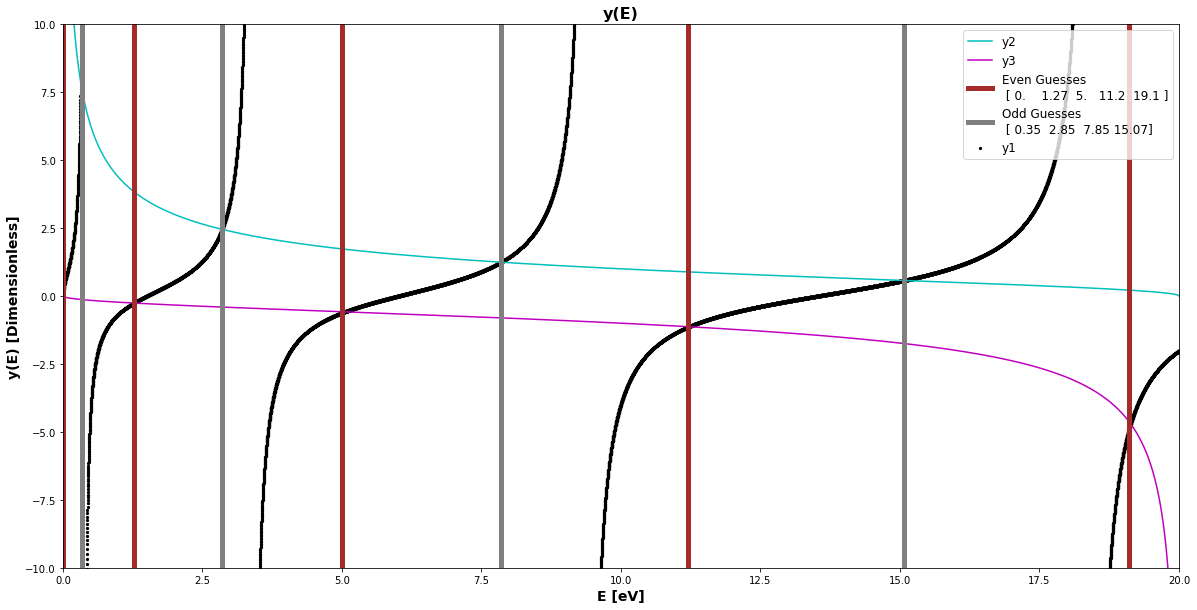

In [4]:
plt.rcParams['figure.figsize'] = (20, 10)
Es = np.arange(0,20,0.001)*u.electronvolt
plt.scatter(Es, y1(Es), label = 'y1', c= 'k', marker = 'o', s = 5)
plt.plot(Es, y2(Es), label = 'y2', c = 'c')
plt.plot(Es, y3(Es), label = 'y3', c = 'm')
plt.ylim(-10,10)
plt.xlim(0,20)
y1s = y1(Es)
y2s = y2(Es)
y3s = y3(Es)
#Getting a rough guess 

odd_guesses = [0.35, 2.85, 7.85, 15.07]*u.electronvolt
even_guesses = [0, 1.27, 5.0, 11.2, 19.1]*u.electronvolt
#idx = np.argwhere(np.diff(np.sign(y1s - y2s))).flatten()
#plt.plot(Es[idx], y1s[idx], 'bo', label = 'Even Intersections', markersize = 10)
#evens = Es[idx]
#idx = np.argwhere(np.diff(np.sign(y1s - y3s))).flatten()
#plt.plot(Es[idx][0::2], y3s[idx][0::2], 'ro', label = 'Odd Intersections', markersize = 10)
#odds = Es[idx][0::2]
for eguess in even_guesses:
    plt.axvline(eguess.value, c= 'brown', label = f'Even Guesses \n {even_guesses.value}', lw = 5)
for oguess in odd_guesses:
    plt.axvline(oguess.value, c= 'grey', label = f'Odd Guesses \n {odd_guesses.value}', lw=5)
plt.title('y(E)')
plt.xlabel('E [eV]')
plt.ylabel('y(E) [Dimensionless]')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), fontsize = 'large', loc = 'upper right');

In [5]:
energies = [even_guesses[0], odd_guesses[0], even_guesses[1], odd_guesses[1], even_guesses[2], odd_guesses[2],
           even_guesses[3]]
n=0
print('Energy Estimations: Initial Guesses')
for e in energies:
    print(f'\n n={n}: {e}')
    n+=1

Energy Estimations: Initial Guesses

 n=0: 0.0 eV

 n=1: 0.35 eV

 n=2: 1.27 eV

 n=3: 2.85 eV

 n=4: 5.0 eV

 n=5: 7.85 eV

 n=6: 11.2 eV


b) Write a second program to calculate the values of the rst six energy levels in electron
volts to an accuracy of 0.001 eV using binary search

The binary method we covered in class was designed to find roots at 0. We need to adapt that method to a function equal to another function. To make sure that I have the method fully grasped, I will start with a very simple example and build from there. 


Below, I am creating a binary search method function for the case where we want to find roots of a function. I will run this function on

$y = x^3$

because this is a simple function with a clear root at x=0.

In [107]:
def binary(x1,x2,f,accuracy):
    #If they have opposite signs, the product should evaluate to False.
    if ((f(x1)== f(x2)) & (f(x1)==0)) | (f(x1)*f(x2)>0) != True:
        midpoint = (x1+x2)//2
        fprime = f(midpoint)
        if fprime*f(x1)>0:
            x1 = midpoint
            if abs(x1-x2)>accuracy:
                return (x1+x2)//2
                print(x1, x2)
            else:
                return binary(x1,x2,f, accuracy)
                print(x1, x2)
        else:
            x2 = midpoint
            if abs(x1-x2)>accuracy:
                return (x1+x2)//2
                print(x1, x2)
            else:
                return  binary(x1,x2,f, accuracy)
                print(x1, x2)
    else:
        print('f(x1) and f(x2) must have opposite signs')
        print(f(x1), f(x2))
            

In [80]:
def f(x):
    return x**3 

In [8]:
a = binary(x1 = .05,x2 = -.05,f = f, accuracy = 0.01)
print(f'The Binary Search Method found a root at {a}.')

The Binary Search Method found a root at 0.0.


<ipython-input-9-904441b39435>:5: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.axvline(0, C = 'gray')
<ipython-input-9-904441b39435>:6: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.axhline(0, C = 'gray')


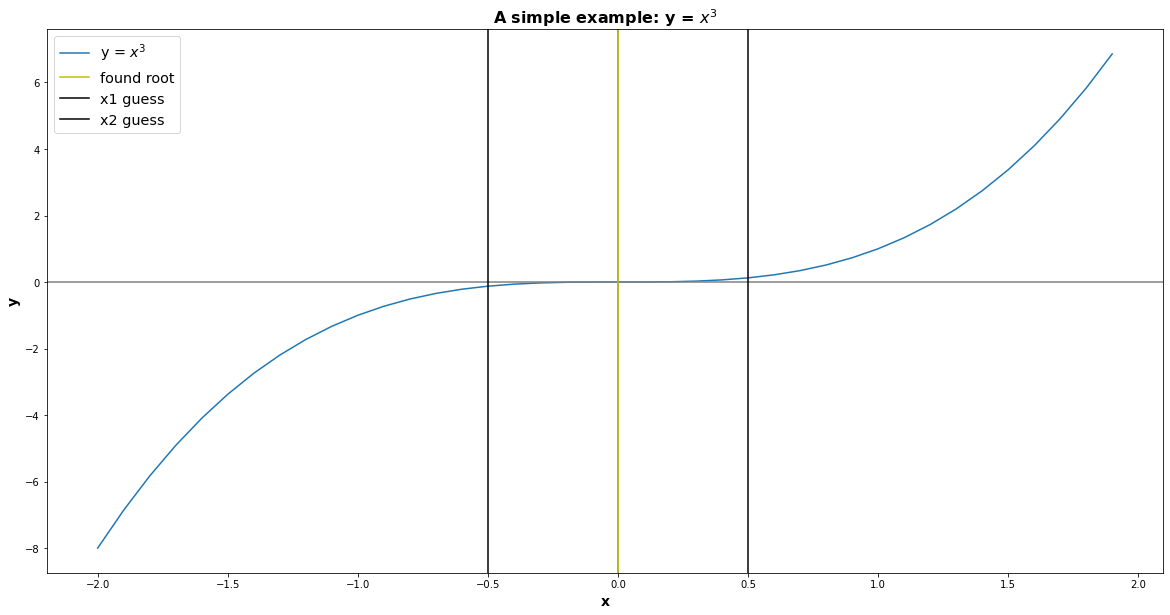

In [9]:
x = np.arange(-2,2, 0.1)
y = x**3
plt.plot(x,y, label = 'y = $x^3$')

plt.axvline(0, C = 'gray')
plt.axhline(0, C = 'gray')
plt.axvline(a, c = 'y', label = 'found root')

plt.axvline(0.5, c = 'k', label = 'x1 guess')
plt.axvline(-0.5, c = 'k', label = 'x2 guess')

plt.legend(fontsize = 'x-large')
plt.xlabel('x')
plt.ylabel('y')
plt.title('A simple example: y = $x^3$');

Now we need to adapt this function. We do not want to find where the function is 0, but where the tangent function intersects the curves.

Again, I'm going to make this example a little more complicated before I apply it to the final problem. 

I will now adapt the function to search for the positive intersection of 

$y = x^3$

and 

$y = 2x$

<ipython-input-77-4b5ac3991dc2>:7: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.axvline(0, C = 'gray')
<ipython-input-77-4b5ac3991dc2>:8: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.axhline(0, C = 'gray')


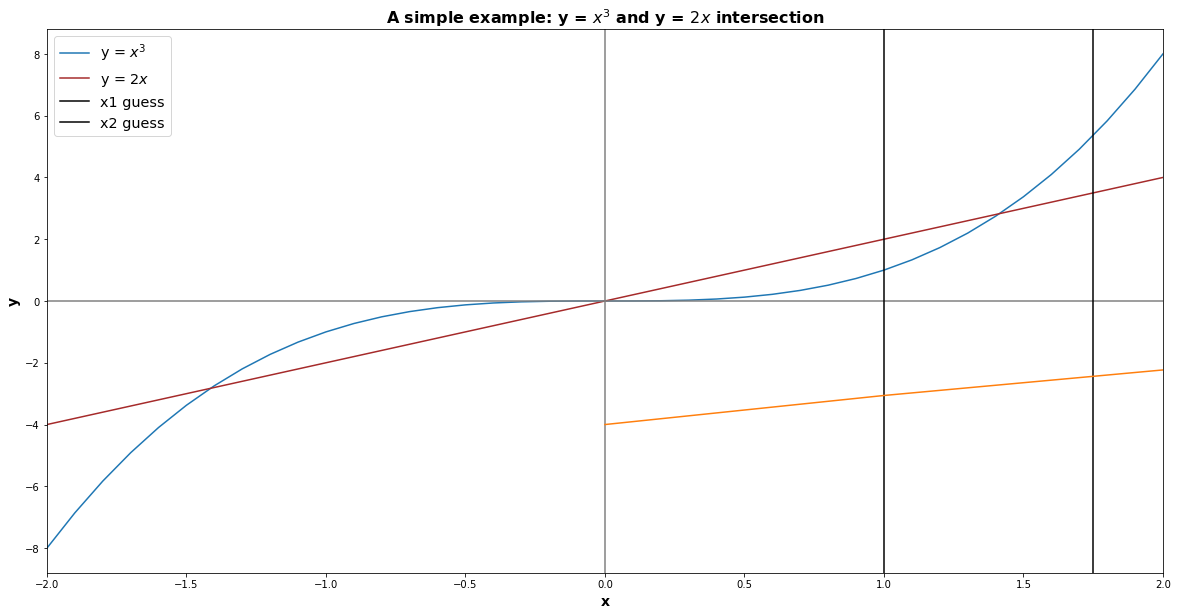

In [77]:
x = np.arange(-2,2.1, 0.1)
y = x**3
y2 = 2*x
plt.plot(x,y, label = 'y = $x^3$')
plt.plot(x,y2, label = 'y = $2x$', c = 'brown')

plt.axvline(0, C = 'gray')
plt.axhline(0, C = 'gray')

plt.axvline(1, c = 'k', label = 'x1 guess')
plt.axvline(1.75, c = 'k', label = 'x2 guess')

plt.legend(fontsize = 'x-large')
plt.xlabel('x')
plt.ylabel('y')
plt.xlim(-2,2)
plt.title('A simple example: y = $x^3$ and y = $2x$ intersection')
plt.plot((x**3) - (2*x));

In [11]:
def binary_two_functions(x1,x2,f,f2,accuracy):
    #f: looking for roots
    #f2 "zero" function
    #If they have opposite signs, the product should evaluate to False.
    #x1 is leftmost point
    if ((f(x1)== f(x2)) & (f(x1)==f2(x2))) | (f(x1)*f(x2)>0) != True:
        midpoint = (x1+x2)//2
        fprime = f(midpoint)
        if (fprime*f(x1))>f2(x1):
            x1 = midpoint
            if abs(x1-x2)>accuracy:
                return (x1+x2)//2
                print(x1, x2)
            else:
                return binary(x1,x2,f, accuracy)
                print(x1, x2)
        else:
            x2 = midpoint
            if abs(x1-x2)>accuracy:
                return (x1+x2)//2
                print(x1, x2)
            else:
                return  binary(x1,x2,f, accuracy)
                print(x1, x2)
    else:
        print('f(x1) and f(x2) must be on opposite sides of the root')
            
        

In [68]:
def f2(x):
    return (x**3) - (x*2)

In [93]:
def func_even(E):
    return y1(E) - y2(E)

In [94]:
def func_odd(E):
    return y1(E) - y3(E)

In [109]:
guess1 = even_guesses[1]-.1*even_guesses[1].unit
guess2 = even_guesses[1]+.1*even_guesses[1].unit
print(even_guesses[1])

1.27 eV


In [108]:
binary(x1 = guess1,x2 = guess2,f = func_even,accuracy = 0.001)

f(x1) and f(x2) must have opposite signs
-4.400537528743237 -3.831945512498899


In [92]:
a = binary(x1 = -4,x2 = -1,f = f2, accuracy = 0.0001)
a

-2

In [111]:
func_even(1*u.electronvolt)

<Quantity -5.01408032>

# Problem 2

Problem 2: Asymmetric quantum well
Quantum mechanics can be formulated as a matrix problem and solved on a computer us-
ing linear algebra methods. Suppose, for example, we have a particle of mass M in a one-
dimensional quantum well of width L, but not a square well like the examples you’ve probably
seen before. Suppose instead that the potential V ( x ) varies somehow inside the well:
1
x = 0 x = L
V(x)
We cannot solve such problems analytically in general, but we can solve them on the computer.
In a pure state of energy E, the spatial part of the wavefunction obeys the time-independent
Schr  ̈odinger equation ˆHψ ( x ) = Eψ ( x ) , where the Hamiltonian operator ˆH is given by
ˆH = −  ̄h 2
2M
d 2
dx 2 + V ( x ) .
For simplicity, let’s assume that the walls of the well are innitely high, so that the wavefunc-
tion is zero outside the well, which means it must go to zero at x = 0 and x = L. In that case,
the wavefunction can be expressed as a Fourier sine series thus:
ψ ( x ) =
∞
∑
n = 1
ψn sin πnx
L ,
where ψ1 , ψ2 , . . . are the Fourier coefcients. Noting that, for m, n positive integers
∫ L
0
sin πmx
L sin πnx
L dx =
{L/2 if m = n,
0 otherwise,
it can be showm that the Schr  ̈odinger equation ˆHψ = Eψ implies that
∞
∑
n = 1
ψn
∫ L
0
sin πmx
L ˆH sin πnx
L dx = 1
2 LEψm .
Hence, dening a matrix H with elements
Hmn = 2
L
∫ L
0
sin πmx
L ˆH sin πnx
L dx
= 2
L
∫ L
0
sin πmx
L
[
−  ̄h 2
2M
d 2
dx 2 + V ( x )
]
sin πnx
L dx,
the Schr  ̈odinger’s equation can be written in matrix form as Hψ = Eψ, where ψ is the vec-
tor ( ψ1 , ψ2 , . . . ) . Thus ψ is an eigenvector of the Hamiltonian matrix H with eigenvalue E. If we
can calculate the eigenvalues of this matrix, then we know the allowed energies of the particle
in the well.
2
a) For the case V ( x ) = ax/L, the integral in Hmn can be evaluated analytically to nd a
general expression for the matrix elements Hmn (where the matrix is real and symmetric):
Hmn =



0 if m ̸ = n and both even or both odd,
− 8amn
π 2 ( m 2 − n 2 ) 2 if m ̸ = n and one is even, one is odd,
a
2 + π 2  ̄h 2 m 2
2ML 2 if m = n.
Write a Python program to evaluate your expression for Hmn for arbitrary m and n when
the particle in the well is an electron, the well has width 5  ̊A, and a = 10 eV. (The mass
and charge of an electron are 9.1094 × 10 − 31 kg and 1.6022 × 10 − 19 C respectively.)
b) The matrix H is in theory innitely large, so we cannot calculate all its eigenvalues. But
we can get a pretty accurate solution for the rst few of them by cutting off the matrix
after the rst few elements. Modify the program you wrote for part (a) above to create
a 10 × 10 array of the elements of H up to m, n = 10. Calculate the eigenvalues of this
matrix using the appropriate function from numpy.linalg and hence print out, in units
of electron volts, the rst ten energy levels of the quantum well, within this approxima-
tion. You should nd, for example, that the ground-state energy of the system is around
5.84 eV. (Hint: Bear in mind that matrix indices in Python start at zero, while the indices
in standard algebraic expressions, like those above, start at one. You will need to make
allowances for this in your program.)
c) Modify your program to use a 100 × 100 array instead and again calculate the rst ten
energy eigenvalues. Comparing with the values you calculated in part (c), what do you
conclude about the accuracy of the calculation?
d) Now modify your program once more to calculate the wavefunction ψ ( x ) for the ground
state and the rst two excited states of the well. Use your results to make a graph with
three curves showing the probability density | ψ ( x )| 2 as a function of x in each of these
three states. Pay special attention to the normalization of the wavefunction—it should
satisfy the condition  L
0 | ψ ( x )| 2 dx = 1. Is this true of your wavefunction

a) For the case V ( x ) = ax/L, the integral in Hmn can be evaluated analytically to nd a
general expression for the matrix elements Hmn (where the matrix is real and symmetric):
Hmn =



0 if m ̸ = n and both even or both odd,
− 8amn
π 2 ( m 2 − n 2 ) 2 if m ̸ = n and one is even, one is odd,
a
2 + π 2  ̄h 2 m 2
2ML 2 if m = n.
Write a Python program to evaluate your expression for Hmn for arbitrary m and n when
the particle in the well is an electron, the well has width 5  ̊A, and a = 10 eV. (The mass
and charge of an electron are 9.1094 × 10 − 31 kg and 1.6022 × 10 − 19 C respectively.)


In [14]:
def Hnm(n, m, a, M, L):
    #m does not equal m and both even or both odd
    n = int(n)
    m = int(m)
    if m!=n and ((m%2 == 0 and n%2 ==0)or(m%2 != 0 and n%2 !=0)):
        return 0*u.electronvolt
    elif m!=n and ((m%2 != 0 and n%2 ==0)or(m%2 == 0 and n%2 !=0)):
        return -1*(8*a*n*m)/((np.pi**2)*(((m**2)-(n**2))**2))
    elif m==n:
        return (a/2)+ (((np.pi**2)*(c.hbar**2)*(m**2))/(2*M*(L**2)))

In [15]:
#Testing a few values
n1m1 = Hnm(n=1, m=1, a = 10*u.electronvolt, M = c.m_e, L = 5*u.AA )
n2m5 = Hnm(n=2, m=5, a = 10*u.electronvolt, M = c.m_e, L = 5*u.AA )
n3m5 = Hnm(n=3, m=5, a = 10*u.electronvolt, M = c.m_e, L = 5*u.AA )
print(f'Some test values for Hnm return: \n'+
     f'{round(n1m1.value, 3)} {n1m1.unit} for n=1,m=1 \n'+
     f'{round(n2m5.value, 3)} {n2m5.unit} for n=2,m=5 \n'+
     f'{n3m5}  for n=3,m=5')

Some test values for Hnm return: 
6.504 eV for n=1,m=1 
-0.184 eV for n=2,m=5 
0.0 eV  for n=3,m=5


In [16]:
Hnm(n=0.1, m=0.1, a = 10*u.electronvolt, M = c.m_e, L = 5*u.AA )

<Quantity 5. eV>

b) The matrix H is in theory innitely large, so we cannot calculate all its eigenvalues. But
we can get a pretty accurate solution for the rst few of them by cutting off the matrix
after the rst few elements. Modify the program you wrote for part (a) above to create
a 10 × 10 array of the elements of H up to m, n = 10. Calculate the eigenvalues of this
matrix using the appropriate function from numpy.linalg and hence print out, in units
of electron volts, the rst ten energy levels of the quantum well, within this approxima-
tion. You should nd, for example, that the ground-state energy of the system is around
5.84 eV. (Hint: Bear in mind that matrix indices in Python start at zero, while the indices
in standard algebraic expressions, like those above, start at one. You will need to make
allowances for this in your program.)


## Plotting Hnm

In [17]:
N = 11
#Create an empty matrix of the correct dimensions
xspan = np.linspace(0,10,N)
yspan = np.linspace(0,10,N)
matrix = np.zeros([N,N])
#iterate over each position in the matrix and compute the correct 
for xi, x in enumerate(xspan):
    for yi, y in enumerate(yspan):
        
        matrix[xi, yi] = Hnm(n=x, m=y, a = 10*u.electronvolt, M = c.m_e, L = 5*u.AA ).value

In [18]:
x = np.delete(matrix, (0), axis=0)
new_matrix =np.delete(x, (0), axis=1)
new_matrix.shape

(10, 10)

<ipython-input-19-3cf5ce5c93b9>:3: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("pink").copy()
  cm.set_bad(color='grey')


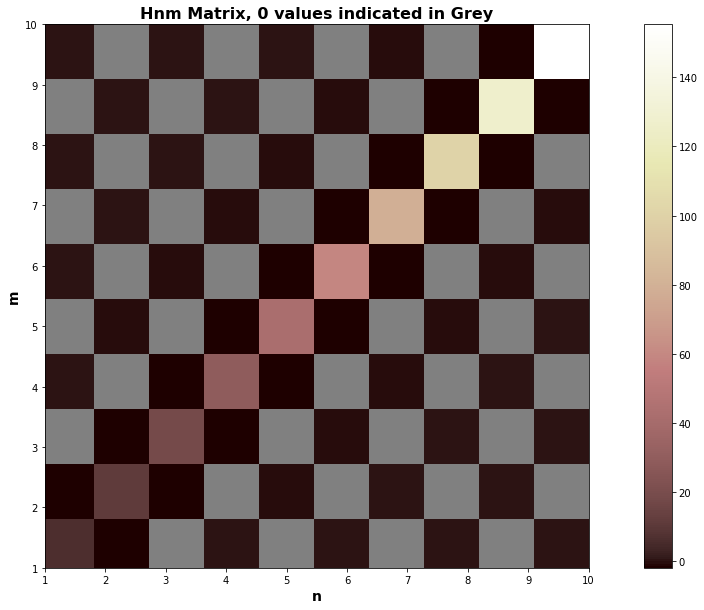

In [19]:
masked_array = np.ma.masked_where(matrix == 0, matrix)
cm = plt.cm.pink
cm.set_bad(color='grey')


plt.imshow(masked_array, cmap=cm, extent = [0,10,0,10],
          interpolation = 'nearest', origin = 'lower')
plt.colorbar()
plt.xlim(1,10)
plt.ylim(1,10)
plt.title('Hnm Matrix, 0 values indicated in Grey')
plt.xlabel('n')
plt.ylabel('m');

This matrix makes sense. We would expect a bright coloration along the diagonal and then a drop off.

## Finding Eigenvalues

In [20]:
eigen_vals1 = sorted(np.linalg.eig(new_matrix)[0])*u.eV
n=1
print('The first ten energy levels of the quantum well are:')
for eig in eigen_vals1:
    print(f'\n {n}: {round(eig.value,3)} {eig.unit}')
    n+=1

The first ten energy levels of the quantum well are:

 1: 5.836 eV

 2: 11.181 eV

 3: 18.663 eV

 4: 29.144 eV

 5: 42.655 eV

 6: 59.185 eV

 7: 78.729 eV

 8: 101.285 eV

 9: 126.851 eV

 10: 155.555 eV


c) Modify your program to use a 100 × 100 array instead and again calculate the rst ten
energy eigenvalues. Comparing with the values you calculated in part (c), what do you
conclude about the accuracy of the calculation?


In [21]:
N = 101
#Create an empty matrix of the correct dimensions
xspan = np.linspace(0,100,N)
yspan = np.linspace(0,100,N)
matrix = np.zeros([N,N])
#iterate over each position in the matrix and compute the correct 
for xi, x in enumerate(xspan):
    for yi, y in enumerate(yspan):
        
        matrix[xi, yi] = Hnm(n=x, m=y, a = 10*u.electronvolt, M = c.m_e, L = 5*u.AA ).value

In [22]:
x = np.delete(matrix, (0), axis=0)
new_matrix =np.delete(x, (0), axis=1)
new_matrix.shape

(100, 100)

<ipython-input-23-12576215621b>:3: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("pink").copy()
  cm.set_bad(color='grey')


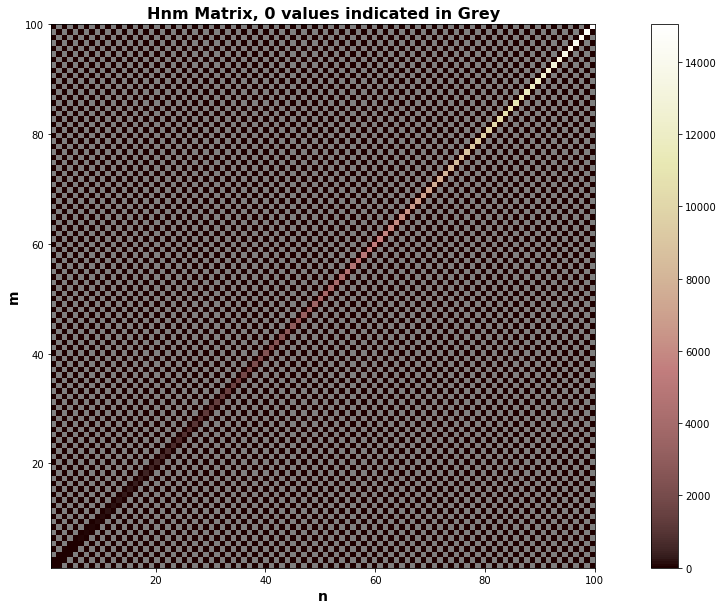

In [23]:
masked_array = np.ma.masked_where(new_matrix == 0, new_matrix)
cm = plt.cm.pink
cm.set_bad(color='grey')


plt.imshow(masked_array, cmap=cm,
         interpolation = 'nearest', extent=[1,100,1,100], origin = 'lower')
plt.colorbar()
plt.xlim(1,100)
plt.ylim(1,100)

plt.title('Hnm Matrix, 0 values indicated in Grey')
plt.xlabel('n')
plt.ylabel('m');

In [24]:
eigen_vals2 = sorted(np.linalg.eig(new_matrix)[0])*u.eV
n=1
print('The first ten energy levels of the quantum well are:')
for eig in eigen_vals2[0:10]:
    print(f'\n {n}: {round(eig.value,3)} {eig.unit}')
    n+=1

The first ten energy levels of the quantum well are:

 1: 5.836 eV

 2: 11.181 eV

 3: 18.663 eV

 4: 29.144 eV

 5: 42.655 eV

 6: 59.185 eV

 7: 78.729 eV

 8: 101.285 eV

 9: 126.851 eV

 10: 155.426 eV


In [25]:
diffs = abs(eigen_vals1-eigen_vals2[0:10])
print('The difference between each eigenvlaue is:')
n=1
for d in diffs:
    print(f'\n{n}: {d}')
    n+=1

The difference between each eigenvlaue is:

1: 4.0068119133707114e-07 eV

2: 1.3232675417640394e-06 eV

3: 1.8710104185970522e-06 eV

4: 8.799646082024992e-06 eV

5: 9.120112210325715e-06 eV

6: 5.2582991173721894e-05 eV

7: 5.182705626793904e-05 eV

8: 0.0006309310799821333 eV

9: 0.0008323257285383079 eV

10: 0.12962246832520918 eV


We can see from this that the differences are very low for lower energies and climb for higher energies, but still remain relatively low.

d) Now modify your program once more to calculate the wavefunction ψ ( x ) for the ground
state and the rst two excited states of the well. Use your results to make a graph with
three curves showing the probability density | ψ ( x )| 2 as a function of x in each of these
three states. Pay special attention to the normalization of the wavefunction—it should
satisfy the condition  L
0 | ψ ( x )| 2 dx = 1. Is this true of your wavefunction

Thus ψ is an eigenvector of the Hamiltonian matrix H with eigenvalue E

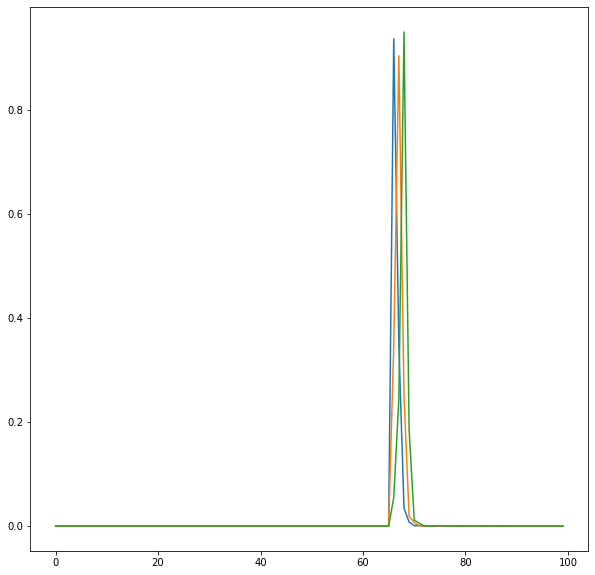

In [340]:
for i in np.linalg.eig(new_matrix)[1][0:3]:
    plt.plot(abs(i))

In [ ]:
def psi()

# Problem 3

Consider the equation x = 1 − e − cx , where c is a known parameter and x is unknown. This
equation arises in a variety of situations, including the physics of contact processes, mathemat-
ical models of epidemics, and the theory of random graphs.
a) Write a program to solve this equation for x using the relaxation method for the case
c = 2. Calculate your solution to an accuracy of at least 10 − 6 .
b) Modify your program to calculate the solution for values of c from 0 to 3 in steps of 0.01
and make a plot of x as a function of c. You should see a clear transition from a regime
in which x = 0 to a regime of nonzero x. This is another example of a phase transition.
3
In physics this transition is known as the percolation transition; in epidemiology it is the
epidemic threshold.
The ordinary relaxation method involves iterating the equation x ′ = f ( x ) , starting from
an initial guess, until it converges. As we have seen, this is often a fast and easy way to nd
solutions to nonlinear equations. However, it is possible in some cases to make the method
work even faster using the technique of overrelaxation. Suppose our initial guess at the solution
of a particular equation is, say, x = 1, and the nal, true solution is x = 5. After the rst step of
the iterative process, we might then see a value of, say, x = 3. In the overrelaxation method, we
observe this value and note that x is increasing, then we deliberately overshoot the calculated
value, in the hope that this will get us closer to the nal solution—in this case we might pass
over x = 3 and go straight to a value of x = 4 perhaps, which is closer to the nal solution of
x = 5 and hence should get us to that solution quicker. The overrelaxation method provides a
formula for performing this kind of overshooting in a controlled fashion and often, though not
always, it does get us to our solution faster. In detail, it works as follows.
We can rewrite the equation x ′ = f ( x ) in the form x ′ = x + ∆x, where
∆x = x ′ − x = f ( x ) − x.
The overrelaxation method involves iteration of the modied equation
x ′ = x + ( 1 + ω ) ∆x,
(keeping the denition of ∆x the same). If the parameter ω is zero, then this is the same as the
ordinary relaxation method, but for ω > 0 the method takes the amount ∆x by which the value
of x would have been changed and changes by a little more. Using ∆x = f ( x ) − x, we can also
write x ′ as
x ′ = x + ( 1 + ω )  f ( x ) − x = ( 1 + ω ) f ( x ) − ωx,
which is the form in which it is usually written.
For the method to work the value of ω must be chosen correctly, although there is some
wiggle room—there is an optimal value, but other values close to it will typically also give
good results. Unfortunately, there is no general theory that tells us what the optimal value is
(usually it is found by trial and error). For the overrelaxation method, it can be shown that the
error on x ′ is given by
ε ′ ≃ x − x ′
1 − 1/ [( 1 + ω ) f ′ ( x ) − ω ] .
c) Consider again the equation x = 1 − e − cx . Take the program you wrote for part (a), which
solved the equation for the case c = 2, and modify it to print out the number of iterations
it takes to converge to a solution accurate to 10 − 6 .
d) Now write a new program (or modify the previous one) to solve the same equation x =
1 − e − cx for c = 2, again to an accuracy of 10 − 6 , but this time using overrelaxation. Have
your program print out the answers it nds along with the number of iterations it took to
nd them. Experiment with different values of ω to see how fast you can get the method
to converge. A value of ω = 0.5 is a reasonable starting point. With some trial and error
you should be able to get the calculation to converge about twice as fast as the simple
relaxation method, i.e., in about half as many iterations.
4
e) Are there any circumstances under which using a value ω < 0 would help us nd a so-
lution faster than we can with the ordinary relaxation method? (Hint: The answer is yes,
but why?)

a) Write a program to solve this equation for x using the relaxation method for the case
c = 2. Calculate your solution to an accuracy of at least 10 − 6 .


In [26]:
def eqn(x,C):
    return 1-np.exp(-1*C*x)

In [27]:
#This is just an example from the book- mostly following its format
x = 0.8
accur = 1e-6
k = 0
error = 1
while error >accur:
    xp = x
    x=eqn(x,2)
    k+=1
    error = abs(x-xp)
    print(x, f'error = {error}')

0.7981034820053446 error = 0.0018965179946554
0.797336227053534 error = 0.0007672549518106253
0.7970249987564617 error = 0.0003112282970723079
0.7968986162987747 error = 0.00012638245768703538
0.7968472729060803 error = 5.1343392694414014e-05
0.7968264107344757 error = 2.0862171604574264e-05
0.7968179332730492 error = 8.477461426514843e-06
0.7968144883075782 error = 3.444965471000039e-06
0.7968130883686114 error = 1.3999389667507245e-06
0.7968125194692648 error = 5.688993466312908e-07


b) Modify your program to calculate the solution for values of c from 0 to 3 in steps of 0.01
and make a plot of x as a function of c. You should see a clear transition from a regime
in which x = 0 to a regime of nonzero x. This is another example of a phase transition.
3
In physics this transition is known as the percolation transition; in epidemiology it is the
epidemic threshold.
The ordinary relaxation method involves iterating the equation x ′ = f ( x ) , starting from
an initial guess, until it converges. As we have seen, this is often a fast and easy way to nd
solutions to nonlinear equations. However, it is possible in some cases to make the method
work even faster using the technique of overrelaxation. Suppose our initial guess at the solution
of a particular equation is, say, x = 1, and the nal, true solution is x = 5. After the rst step of
the iterative process, we might then see a value of, say, x = 3. In the overrelaxation method, we
observe this value and note that x is increasing, then we deliberately overshoot the calculated
value, in the hope that this will get us closer to the nal solution—in this case we might pass
over x = 3 and go straight to a value of x = 4 perhaps, which is closer to the nal solution of
x = 5 and hence should get us to that solution quicker. The overrelaxation method provides a
formula for performing this kind of overshooting in a controlled fashion and often, though not
always, it does get us to our solution faster. In detail, it works as follows.
We can rewrite the equation x ′ = f ( x ) in the form x ′ = x + ∆x, where
∆x = x ′ − x = f ( x ) − x.
The overrelaxation method involves iteration of the modied equation
x ′ = x + ( 1 + ω ) ∆x,
(keeping the denition of ∆x the same). If the parameter ω is zero, then this is the same as the
ordinary relaxation method, but for ω > 0 the method takes the amount ∆x by which the value
of x would have been changed and changes by a little more. Using ∆x = f ( x ) − x, we can also
write x ′ as
x ′ = x + ( 1 + ω )  f ( x ) − x = ( 1 + ω ) f ( x ) − ωx,
which is the form in which it is usually written.
For the method to work the value of ω must be chosen correctly, although there is some
wiggle room—there is an optimal value, but other values close to it will typically also give
good results. Unfortunately, there is no general theory that tells us what the optimal value is
(usually it is found by trial and error). For the overrelaxation method, it can be shown that the
error on x ′ is given by
ε ′ ≃ x − x ′
1 − 1/ [( 1 + ω ) f ′ ( x ) − ω ] .


In [28]:
def find_x(C):
    x = 0.8
    accur = 1e-6
    k = 0
    error = 1
    while error >accur:
        xp = x
        x=eqn(x,C)
        k+=1
        error = abs(x-xp)
    return(x)

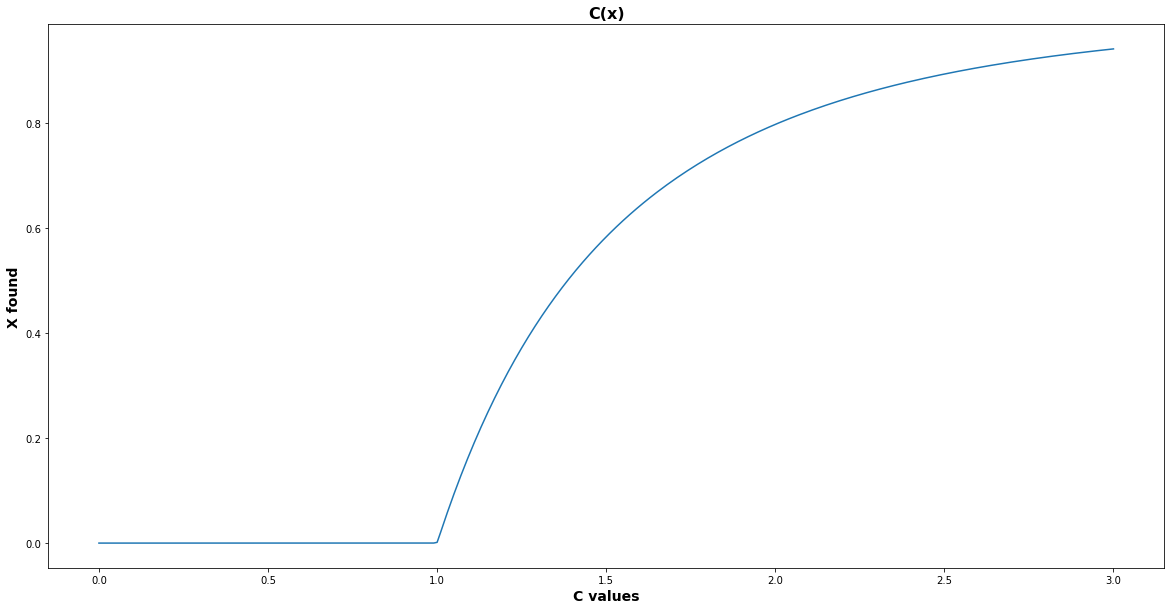

In [29]:
cs = np.arange(0,3.01,.01)
xvals = []
for C in cs:
    xvals.append(find_x(C))
plt.plot(cs, xvals)
plt.xlabel('C values')
plt.ylabel('X found')
plt.title('C(x)');

c) Consider again the equation x = 1 − e − cx . Take the program you wrote for part (a), which
solved the equation for the case c = 2, and modify it to print out the number of iterations
it takes to converge to a solution accurate to 10 − 6 .


In [30]:
def find_x(C):
    x = 0.8
    accur = 1e-6
    k = 0
    error = 1
    while error >accur:
        xp = x
        x=eqn(x,C)
        k+=1
        error = abs(x-xp)
    return(k)

In [31]:
print(f'It took {find_x(2)} iterations to converge to a solution.')

It took 10 iterations to converge to a solution.


d) Now write a new program (or modify the previous one) to solve the same equation x =
1 − e − cx for c = 2, again to an accuracy of 10 − 6 , but this time using overrelaxation. Have
your program print out the answers it nds along with the number of iterations it took to
nd them. Experiment with different values of ω to see how fast you can get the method
to converge. A value of ω = 0.5 is a reasonable starting point. With some trial and error
you should be able to get the calculation to converge about twice as fast as the simple
relaxation method, i.e., in about half as many iterations.
4


In [32]:
def find_x(C, w):
    x = 0.8
    accur = 1e-6
    k = 0
    error = 1
    while error >accur:
        xp = x
        deltx = eqn(x,C)-x
        x+=(1*w)*deltx
        k+=1
        error = abs(x-xp)
        print( f'{k} iterations:', x)

In [33]:
find_x(2,1.7)

1 iterations: 0.7967759194090859
2 iterations: 0.7968124608483369
3 iterations: 0.7968121269891462


For an $\omega$ value of 1.7, it only takes 3 iterations for the code to converge. This is a little over 3 times faster than the simpler relaxation method.

e) Are there any circumstances under which using a value ω < 0 would help us nd a so-
lution faster than we can with the ordinary relaxation method? (Hint: The answer is yes,
but why?)

# Problem 4

Problem 4: Detecting periodicity
Let’s analyze again the data in sunspots.txt (from Homework #2), which contains the ob-
served number of sunspots on the Sun for each month since January 1749. The le contains
two columns of numbers, the rst representing the month and the second being the sunspot
number.
a) Write a program that reads the data in the le and makes a graph of sunspots as a function
of time. You should see that the number of sunspots has uctuated on a regular cycle for
as long as observations have been recorded. Make an estimate of the length of the cycle
in months.
b) Modify your program to calculate the Fourier transform of the sunspot data and then
make a graph of the magnitude squared | c k | 2 of the Fourier coefcients as a function
of k—also called the power spectrum of the sunspot signal. You should see that there
is a noticeable peak in the power spectrum at a nonzero value of k. The appearance
of this peak tells us that there is one frequency in the Fourier series that has a higher
amplitude than the others around it—meaning that there is a large sine-wave term with
this frequency, which corresponds to the periodic wave you can see in the original data.
c) Find the approximate value of k to which the peak corresponds. What is the period of the
sine wave with this value of k? You should nd that the period corresponds roughly to
the length of the cycle that you estimated in part (a).
This kind of Fourier analysis is a sensitive method for detecting periodicity in signals. Even in
cases where it is not clear to the eye that there is a periodic component to a signal, it may still
be possible to nd one using a Fourier transform

a) Write a program that reads the data in the le and makes a graph of sunspots as a function
of time. You should see that the number of sunspots has uctuated on a regular cycle for
as long as observations have been recorded. Make an estimate of the length of the cycle
in months.


In [300]:
def read_sunspots(path):
    """
    Reads in a file containing information about sunspot data and produces a plot of the sunspots over time
    
    Parameters
    ---
    path: string, absolute path to the sunspot file
    
    Returns
    ---
    Produces a matplotlib plot of the sunspots over time. Sunspot count is the number of sunspots observed
    in a given month since 01-01-1749.

    """
    #Define an empty list to store the dates
    plt.rcParams['figure.figsize'] = (20, 10)
    dates = []
    #Read in the file as a pandas DataFrame, indicate that the file contains to headers
    df = pd.read_table(path, header = None)
    #Months are indicated in the first column and spot counts are indicated in the second
    months = df[0].values
    spots = np.array(df[1].values)
    plt.plot(months, spots, label = 'Data')
    plt.axvline(600, c='k', label = 'Arbitrary peak bound')
    plt.axvline(700, c ='k')
    plt.title('Sunspots over time')
    plt.xlabel('Months since 01-01-1749')
    plt.ylabel('Sunspot Count')
    plt.legend();
    return spots, months

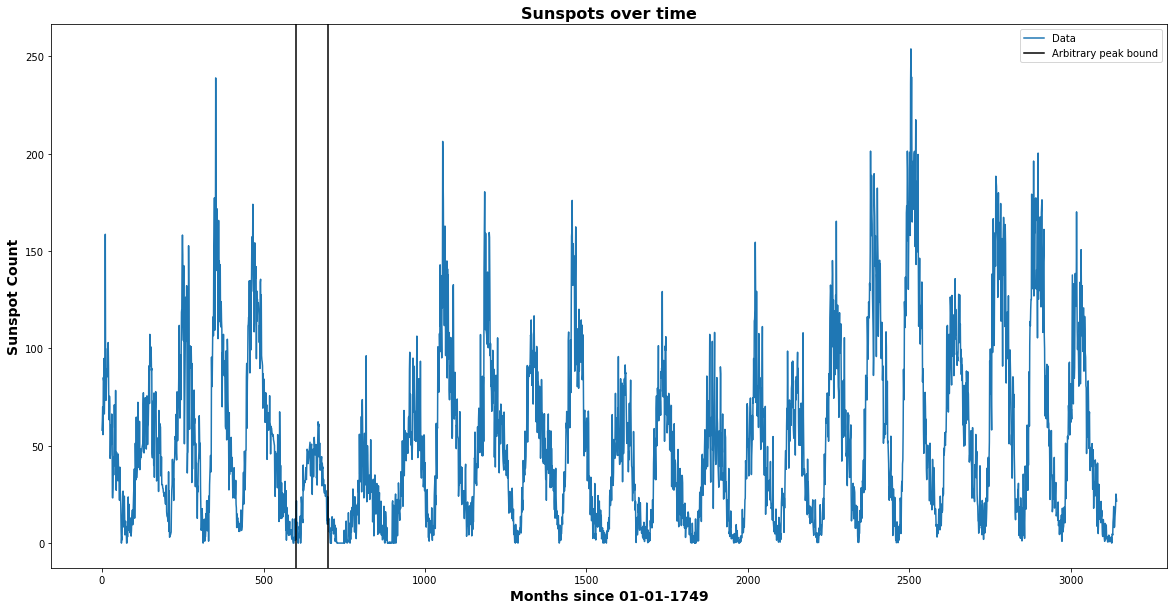

In [301]:
spots, months = read_sunspots(path = '/home/kelcey/computational_phys/Homewrok2/sunspots.txt')

In [42]:
guess = 700-600
print(f'I will make an arbitrary guess that the cycle repeats every {guess} months.')

I will make an arbitrary guess that the cycle repeats every 100 months.


b) Modify your program to calculate the Fourier transform of the sunspot data and then
make a graph of the magnitude squared | c k | 2 of the Fourier coefcients as a function
of k—also called the power spectrum of the sunspot signal. You should see that there
is a noticeable peak in the power spectrum at a nonzero value of k. The appearance
of this peak tells us that there is one frequency in the Fourier series that has a higher
amplitude than the others around it—meaning that there is a large sine-wave term with
this frequency, which corresponds to the periodic wave you can see in the original data.


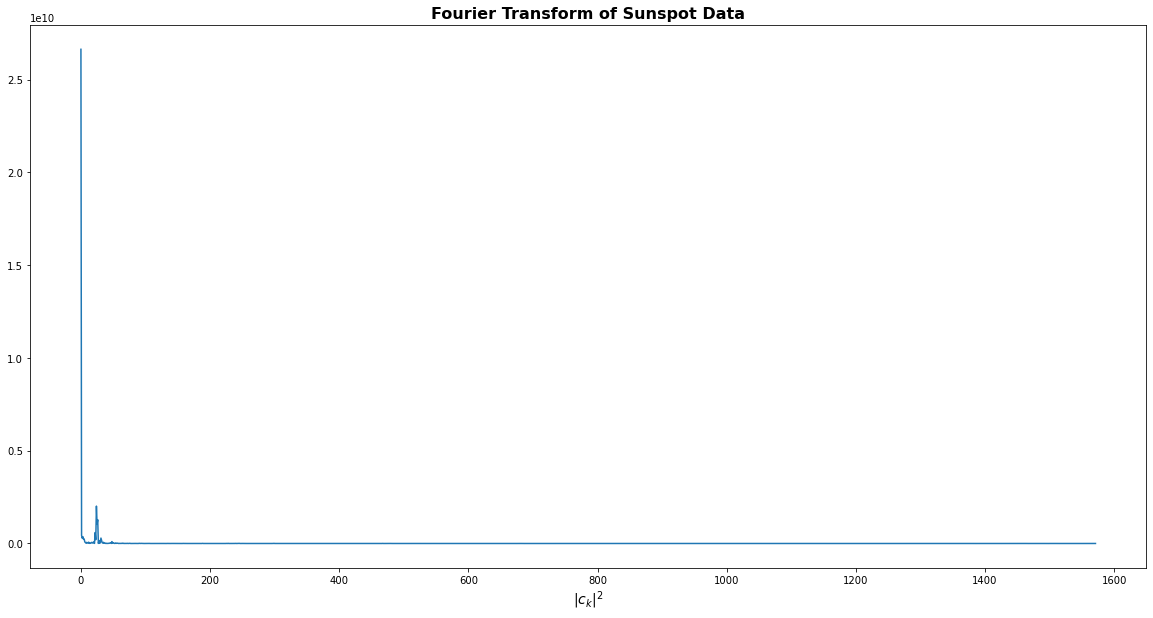

In [313]:
plt.rcParams['figure.figsize'] = (20, 10)
plt.plot(np.abs(rfft(spots))**2)
plt.title('Fourier Transform of Sunspot Data')
plt.xlabel('$|c_k|^2$');

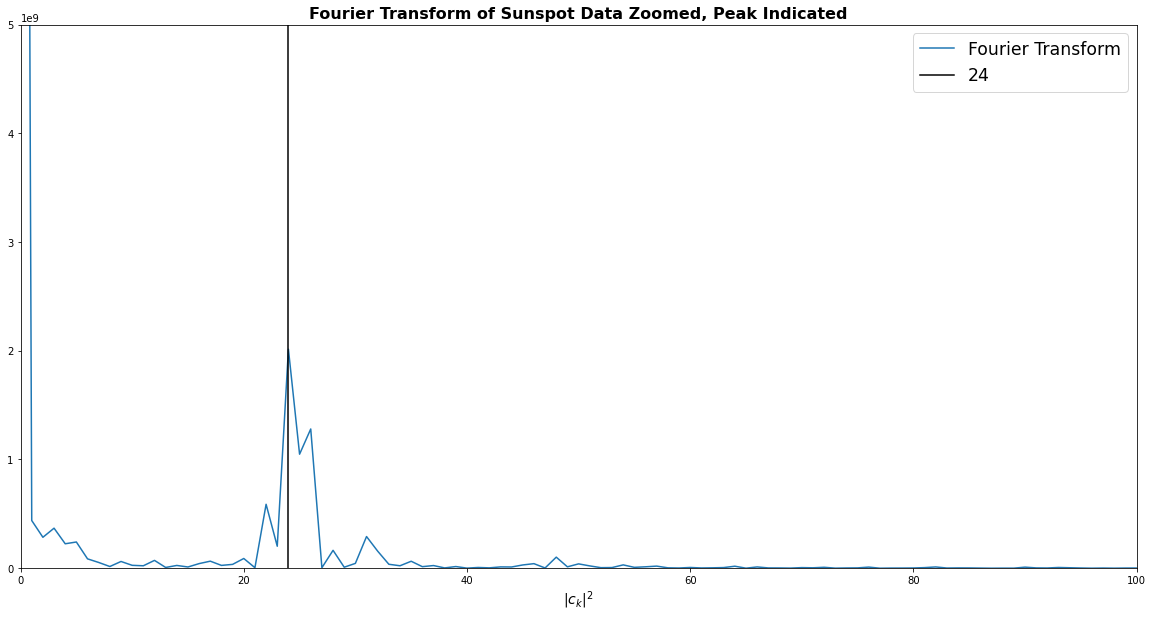

In [311]:
plt.rcParams['figure.figsize'] = (20, 10)
plt.plot(np.abs(rfft(spots))**2, label = 'Fourier Transform')
plt.xlim(0,100)
plt.ylim(0,.5*1e10)
mx = np.argmax((np.abs(rfft(spots))**2)[10:])+10
plt.axvline(mx, c= 'k', label = f'{mx}')
plt.title('Fourier Transform of Sunspot Data Zoomed, Peak Indicated')
plt.xlabel('$|c_k|^2$')
plt.legend(fontsize = 'xx-large');

c) Find the approximate value of k to which the peak corresponds. What is the period of the
sine wave with this value of k? You should nd that the period corresponds roughly to
the length of the cycle that you estimated in part (a).
This kind of Fourier analysis is a sensitive method for detecting periodicity in signals. Even in
cases where it is not clear to the eye that there is a periodic component to a signal, it may still
be possible to nd one using a Fourier transform

# Problem 5



n the web site you will nd a le called blur.txt that contains a grid of values repre-
senting brightness on a black-and-white photo—a badly out-of-focus one that has been
deliberately blurred using a Gaussian point spread function of width σ = 25. Write a
program that reads the grid of values into a two-dimensional array of real numbers and
then draws the values on the screen of the computer as a density plot. You should see
the photo appear. If you get something wrong it might be upside-down. Work with the
details of your program until you get it appearing correctly. (Hint: The picture has the
sky, which is bright, at the top and the ground, which is dark, at the bottom.)
7


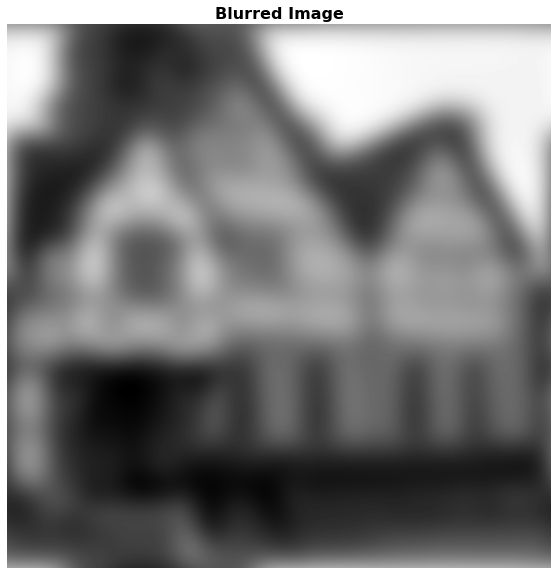

In [192]:
data = np.loadtxt('/home/kelcey/Downloads/blur.txt')
plt.imshow(data, cmap = 'gray')
plt.axis('off')
plt.title('Blurred Image');

b) Write another program that creates an array, of the same size as the photo, containing a
grid of samples drawn from the Gaussian f ( x, y ) above with σ = 25. Make a density
plot of these values on the screen too, so that you get a visualization of your point spread
function. Remember that the point spread function is periodic (along both axes), which
means that the values for negative x and y are repeated at the end of the interval. Since
the Gaussian is centered on the origin, this means there should be bright patches in each
of the four corners of your picture, something like this:


In [327]:
def f(x,y, sigma):
    return np.e**(-1*(((x**2) + (y**2))/(2*(sigma**2))))

In [328]:
sigma = 25
Nx = data.shape[0]
Ny = data.shape[1]
xspan = np.linspace(-Nx/2,Nx/2,Nx)
yspan = np.linspace(-Ny/2,Ny/2,Ny)
psf = np.zeros([Nx,Ny])
for xi, x in enumerate(xspan):
    for yi, y in enumerate(yspan):
        psf[xi, yi] += f(x,y, sigma)

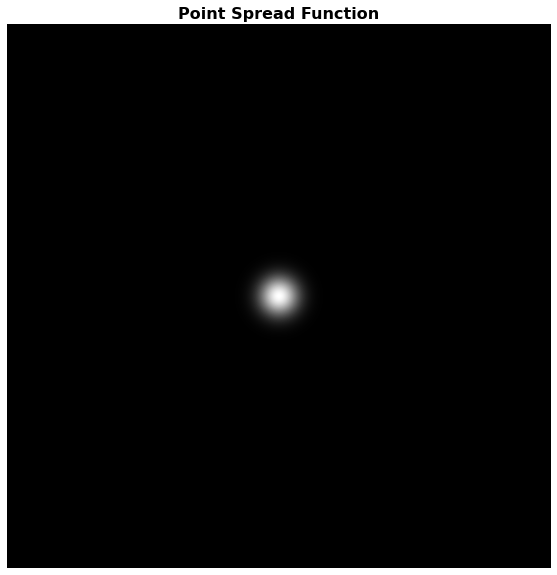

In [329]:
plt.imshow(psf, cmap = 'gray')
plt.axis('off')
plt.title('Point Spread Function');

c) Combine your two programs and add Fourier transforms using the functions rfft2 and
irfft2 from numpy.fft, to make a program that does the following:
i) Reads in the blurred photo
ii) Calculates the point spread function
iii) Fourier transforms both
iv) Divides one by the other
v) Performs an inverse transform to get the unblurred photo
vi) Displays the unblurred photo on the screen
When you are done, you should be able to make out the scene in the photo, although
probably it will still not be perfectly sharp.
Hint: One thing you’ll need to deal with is what happens when the Fourier transform of
the point spread function is zero, or close to zero. In that case if you divide by it you’ll get
an error (because you can’t divide by zero) or just a very large number (because you’re
dividing by something small). A workable compromise is that if a value in the Fourier
transform of the point spread function is smaller than a certain amount ε you don’t divide
by it—just leave that coefcient alone. The value of ε is not very critical but a reasonable
value seems to be 10 − 3 .


In [330]:
def deconvolve(path):
    plt.rcParams['figure.figsize'] = (10, 10)
    data = np.loadtxt(path)
    plt.imshow(data, cmap = 'gray')
    plt.axis('off')
    plt.title('Blurred Image');
    
    sigma = 25
    Nx = data.shape[0]
    Ny = data.shape[1]
    xspan = np.linspace(-Nx/2,Nx/2,Nx)
    yspan = np.linspace(-Ny/2,Ny/2,Ny)
    psf = np.zeros([Nx,Ny])
    for xi, x in enumerate(xspan):
        for yi, y in enumerate(yspan):
            psf[xi, yi] += f(x,y, sigma)
            
    plt.figure()
    plt.imshow(psf, cmap = 'gray')
    plt.axis('off')
    plt.title('Point Spread Function');
    
    plt.figure()

    ft_data = np.abs(rfft2(data))
    ft_ps = np.abs(rfft2(psf))
    
    Nx = ft_data.shape[0]
    Ny = ft_data.shape[1]
    xspan = np.linspace(-Nx/2,Nx/2,Nx)
    yspan = np.linspace(-Ny/2,Ny/2,Ny)
    ft_matrix = np.zeros([Nx,Ny])
    for xi, x in enumerate(xspan):
        for yi, y in enumerate(yspan):
            eps = 1e-3
            ps = ft_ps[xi,yi]
            val = ft_data[xi,yi]/ft_ps[xi,yi]
            if ps>eps:
                ft_matrix[xi, yi] += val
    plt.figure()
    plt.imshow(ft_matrix, cmap = 'gray')
    plt.axis('off')
    plt.title('FT(data)/FT(psf)');
    
    plt.figure()
    plt.imshow(irfft2(ft_matrix), cmap = 'gray')
    plt.axis('off')
    plt.title('Unblurred Image');

<ipython-input-330-d76d5804568a>:37: RuntimeWarning: divide by zero encountered in double_scalars
  val = ft_data[xi,yi]/ft_ps[xi,yi]


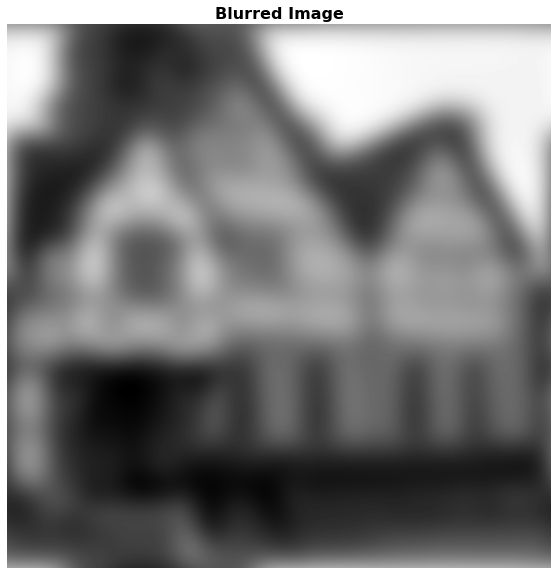

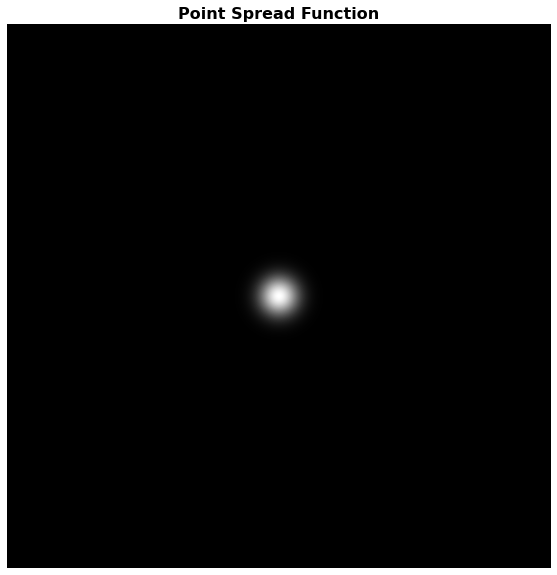

<Figure size 720x720 with 0 Axes>

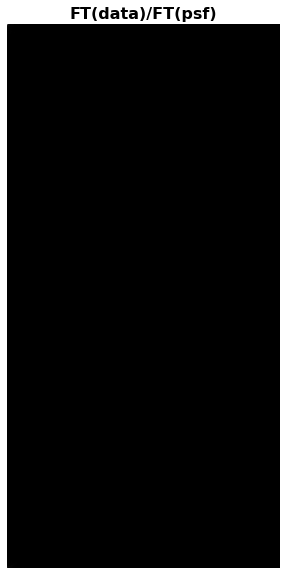

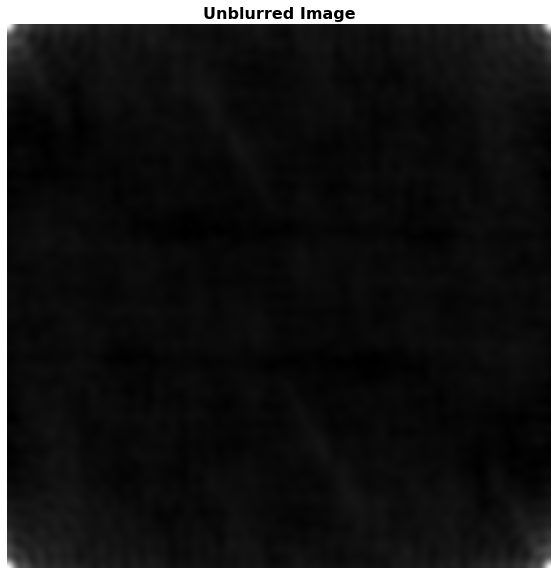

In [331]:
path = '/home/kelcey/Downloads/blur.txt'
deconvolve(path)

d) Bearing in mind this last point about zeros in the Fourier transform, what is it that limits
our ability to deblur a photo? Why can we not perfectly unblur any photo and make it
completely sharp?
We have seen this process in action here for a normal snapshot, but it is also used in many
physics applications where one takes photos. For instance, it is used in astronomy to enhance
8
photos taken by telescopes. It was famously used with images from the Hubble Space Tele-
scope after it was realized that the telescope’s main mirror had a serious manufacturing aw
and was returning blurry photos—scientists managed to partially correct the blurring using
Fourier transform tech